In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from scipy import stats
from scipy.stats import norm, skew

In [3]:
# loading the data
data = pd.read_csv('house-prices.csv')
print('Dataset has {} entries and {} features.'.format(data.shape[0], data.shape[1]))

Dataset has 2430 entries and 82 features.


## 1. Preprocessing

In [4]:
# Function for preprocessing the data
def preprocess_df(df):
    
    df_clean = df.copy()
    
    # Features that are not necessary
    columns_to_drop = ['PID', 'Order']
    df_clean = df_clean.drop(columns_to_drop, axis=1)
    
    ###  Removing outliers : very large houses (more than 4000 square feet)
    df_clean = df_clean[df_clean['Gr Liv Area'] < 4000]
    
    ### Handling missing values

    # Features that most likely does not exist if NaN
    columns_to_zero = ['Garage Area', 'Garage Cars', 'Total Bsmt SF', 'Bsmt Half Bath', 'Bsmt Full Bath', 
                      'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF']
    # Fill with NA
    columns_to_NA = ['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu', 'Garage Type',
                 'Garage Finish','Garage Qual','Garage Cond', 'Bsmt Qual' , 'Bsmt Cond' , 'Bsmt Exposure' ,
                 'BsmtFin Type 1' , 'BsmtFin Type 2']
    # ...
    columns_to_none = ['Mas Vnr Type']
    # 
    columns_to_mean = ['Mas Vnr Area', 'Lot Frontage']
    #...
    columns_to_mode = ['Electrical']
    
    df_clean[columns_to_zero] = df[columns_to_zero].fillna(0)
    df_clean[columns_to_NA] = df[columns_to_NA].fillna('NA')
    df_clean[columns_to_none] = df[columns_to_none].fillna('None')
    df_clean[columns_to_mean] = df[columns_to_mean].fillna(df[columns_to_mean].mean())
    df_clean[columns_to_mode] = df[columns_to_mode].fillna(df[columns_to_mode].mode().iloc[0,0]) 
    
    ### Feature engineering:
    
    ## Total counts:
    # Total surface count
    df_clean['Total SF'] = df_clean['Total Bsmt SF'] + df_clean['Gr Liv Area']
    
    # Total room count
    df_clean['Total Rooms'] = (df_clean['TotRms AbvGrd'] + df_clean['Bsmt Full Bath'] + 
                                df_clean['Bsmt Half Bath'] + df_clean['Full Bath'] + df_clean['Half Bath'])
    
    ## Binary features:
    
    # Creating a 'Remodeled' feature (if YearRemodAdd != YearBuilt) 
    df_clean['Remodeled'] = (df_clean['Year Remod/Add'] != df_clean['Year Built']) * 1
    
    # Creating a 'RecentRemodel' feature if a remodeling happenned in the year the house was sold
    df_clean['RecentRemodel'] = (df_clean['Year Remod/Add'] == df_clean['Yr Sold']) * 1
    
    # Creating a 'NewHouse' featureWas this house sold in the year it was built?
    df_clean['NewHouse'] = (df_clean['Year Built'] == df_clean['Yr Sold']) * 1
    
    # Sale seasonality feature (high & low season)
    df_clean['Sale Season'] = df_clean['Mo Sold'].replace({1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:1, 9:0, 10:0, 11:0, 12:0})
    
    ### ENCODING
    
    # Encoding Ordinal variables:
    # assigning a value from 0 (none) / 1 (poor) to 5 or 6 (excellent) to these variables
    quality_features = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC', 'Kitchen Qual',
                    'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Pool QC']
    df_clean[quality_features] = df_clean[quality_features].replace({
        'Ex' : 5, 'Gd' : 4,'TA' : 3, 'Fa' : 2, 'Po' : 1, 'NA' : 0
    })
    
    # Encoding other ordinal variables, with specific 'scales', creating a dict for each variable,
    # and using .replace method
    other_ord_features = {
        'Lot Shape' : {'Reg': 4, 'IR1': 3, 'IR2' : 2, 'IR3' : 1},
        'Utilities' : {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1},
        'Land Slope' : {'Gtl' : 3, 'Mod' : 2, 'Sev' : 1},
        'Bsmt Exposure' : {'Gd' : 4, 'Av' : 3,'Mn' : 2, 'No' : 1, 'NA' : 0},
        'BsmtFin Type 1' : {'GLQ' : 6, 'ALQ' : 5,'BLQ' : 4, 'Rec' : 3, 'LwQ' : 2, 'Unf' : 1, 'NA' : 0},
        'BsmtFin Type 2' : {'GLQ' : 6, 'ALQ' : 5,'BLQ' : 4, 'Rec' : 3, 'LwQ' : 2, 'Unf' : 1, 'NA' : 0},
        'Electrical' : {'SBrkr' : 5, 'FuseA' : 4,'FuseF' : 3, 'FuseP' : 2, 'Mix' : 1},
        'Functional' : {'Typ' : 8, 'Min1' : 7,'Min2' : 6, 'Mod' : 5, 'Maj1' : 4, 'Maj2' : 3, 'Sev' : 2, 'Sal':1},
        'Garage Finish' : {'Fin' : 3, 'RFn' : 2,'Unf' : 1, 'NA' : 0},
        'Paved Drive' : {'Y' : 3, 'P' : 2,'N' : 1},
        'Fence' : {'GdPrv' : 4, 'MnPrv' : 3,'GdWo' : 2, 'MnWw' : 1, 'NA' : 0}
    }
    df_clean = df_clean.replace(other_ord_features)  
                               
    ### Feature engineering continued:
    
    ## Composite features :
    # Overall quality of the house
    df_clean['Overall Grade'] = df_clean['Overall Qual'] * df_clean['Overall Cond']

    # Overall quality of the garage
    df_clean['Garage Grade'] = df_clean['Garage Qual'] * df_clean['Garage Cond']
    
    # Overall quality of the exterior
    df_clean['Exter Grade'] = df_clean['Exter Qual'] * df_clean['Exter Cond']
    
    # Composite of two most correlated features to the Sale Price : TotalSF & Overall Quality
    df_clean['OverallQualxTotalSF'] = df_clean['Total SF'] * df_clean['Overall Qual']
    
                               
    ## Binning years columns
    
    pd.options.mode.chained_assignment = None  # disabling warnings on chained assignment, I think this is the right 
                                                #choice as I am working on a copy anyway
    df_clean['Garage Yr Blt'].loc[df_clean['Garage Yr Blt'] <= 1960] = 1
    df_clean['Garage Yr Blt'].loc[(df_clean['Garage Yr Blt'] > 1960) & (df_clean['Garage Yr Blt'] <= 1978)] = 2
    df_clean['Garage Yr Blt'].loc[(df_clean['Garage Yr Blt'] > 1978) & (df_clean['Garage Yr Blt'] <= 2002)] = 3
    df_clean['Garage Yr Blt'].loc[df_clean['Garage Yr Blt'] > 2002] = 4
    #create a specific bin for misssing values
    df_clean['Garage Yr Blt'].loc[df_clean['Garage Yr Blt'].isnull()] = 0
    
    # Add polynomial features for the 10 most correlated features
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=3, include_bias=False)
    def add_poly(a):
        return poly.fit_transform(df_clean[a][:, np.newaxis])[:,1], poly.fit_transform(df_clean[a][:, np.newaxis])[:,2]

    df_clean['OverallQualxTotalSF_1'], df_clean['OverallQualxTotalSF_2'] = add_poly('OverallQualxTotalSF')
    df_clean['Total SF_1'], df_clean['Total SF_2'] = add_poly('Total SF')
    df_clean['Overall Qual_1'], df_clean['Overall Qual_2'] = add_poly('Overall Qual')
    df_clean['Exter Qual_1'], df_clean['Exter Qual_2'] = add_poly('Exter Qual')
    df_clean['Gr Liv Area_1'], df_clean['Gr Liv Area_2'] = add_poly('Gr Liv Area')
    df_clean['Kitchen Qual_1'], df_clean['Kitchen Qual_2'] = add_poly('Kitchen Qual')
    df_clean['Total Bsmt SF_1'], df_clean['Total Bsmt SF_2'] = add_poly('Total Bsmt SF')
    df_clean['Garage Cars_1'], df_clean['Garage Cars_2'] = add_poly('Garage Cars')
    df_clean['Garage Area_1'], df_clean['Garage Area_2'] = add_poly('Garage Area')
    df_clean['Total Rooms_1'], df_clean['Total Rooms_2'] = add_poly('Total Rooms')
    
    # Final check for missing values
    print('Dataset has {} entries and {} features.'.format(df_clean.shape[0], df_clean.shape[1]))
    print('There are',df_clean.isnull().sum().sum(),'missing values remaining.')
    
    return df_clean

In [5]:
df_clean = preprocess_df(data)

Dataset has 2426 entries and 110 features.
There are 0 missing values remaining.


In [6]:
## Normalization

# Add a LogSalePrice variable to the DataFrame:
df_clean['LogSalePrice'] = np.log10(df_clean['SalePrice'])  

In [7]:
## Classication of the variables

# 1 - Numeric variables
numeric = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
           'Total Bsmt SF_1', 'Total Bsmt SF_2', '1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area',
           'Gr Liv Area_1', 'Gr Liv Area_2', 'Garage Area', 'Garage Area_1', 'Garage Area_2', 
           'Wood Deck SF','Open Porch SF', 'Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area','Misc Val',
           'Total SF', 'Total SF_1', 'Total SF_2', 'OverallQualxTotalSF', 'OverallQualxTotalSF_1',
           'OverallQualxTotalSF_2'
          ]
# 2 - Categorical variables
# 2.1 - Categorical variables, ordinal (possibility of ordering)
categorical_ordinal = ['Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Qual_1', 'Overall Qual_2',
                       'Overall Cond', 'Exter Qual', 'Exter Qual_1', 'Exter Qual_2', 'Exter Cond','Bsmt Qual', 'Bsmt Cond',
                       'Bsmt Exposure', 'BsmtFin Type 1','BsmtFin Type 2', 'Heating QC','Electrical','Kitchen Qual',
                       'Kitchen Qual_1', 'Kitchen Qual_2', 'Functional','Fireplace Qu','Garage Finish','Garage Qual',
                       'Garage Cond','Paved Drive','Pool QC','Fence', 'Overall Grade', 'Garage Grade', 'Exter Grade'
                      ]
# 2.2 - Categorical variables, nominal (no possibility to order) 
categorical_nominal = ['MS SubClass','MS Zoning','Street', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood',
                      'Condition 1', 'Condition 2', 'Bldg Type','House Style','Roof Style', 'Roof Matl','Exterior 1st',
                      'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air','Garage Type','Misc Feature',
                       'Sale Type','Sale Condition', 'Remodeled', 'RecentRemodel', 'NewHouse', 'Sale Season'
                      ]
# 2.3 - Categorical variables, discrete
categorical_discrete = ['Year Built', 'Year Remod/Add','Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath',
                       'Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Yr Blt','Garage Cars',
                        'Garage Cars_1', 'Garage Cars_2', 'Mo Sold', 'Yr Sold', 'Total Rooms', 'Total Rooms_1',
                        'Total Rooms_2'
                       ]
categorical = categorical_ordinal + categorical_nominal + categorical_discrete

In [8]:
# Transform all the skewed feature 
# skew > 0,75 , considered as moderately to highly skewed
# This will make the features more normal.

# Check the skewness of numerical features
numeric_features = pd.Index(numeric)

skewed_features = df_clean[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[abs(skewed_features) > 0.75]
print("\nSkewed numerical features to log transform: \n")
skewness = pd.DataFrame({'Skew' :skewed_features})
skewness.sort_values(by='Skew', ascending = False)


Skewed numerical features to log transform: 



,Skew
Misc Val,20.872760
Pool Area,18.004062
Lot Area,13.132508
Low Qual Fin SF,12.448565
3Ssn Porch,11.896268
OverallQualxTotalSF_2,4.736937
Total Bsmt SF_2,4.484278
Garage Area_2,4.423194
Enclosed Porch,4.182091
BsmtFin SF 2,4.030186


In [9]:
# Log transform of the skewed numerical features 
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed

skewness = skewness[abs(skewness) > 0.75]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
df_clean[skewed_features] = np.log1p(df_clean[skewed_features])

28 skewed numerical features to log transform


### 1.1 Outliers

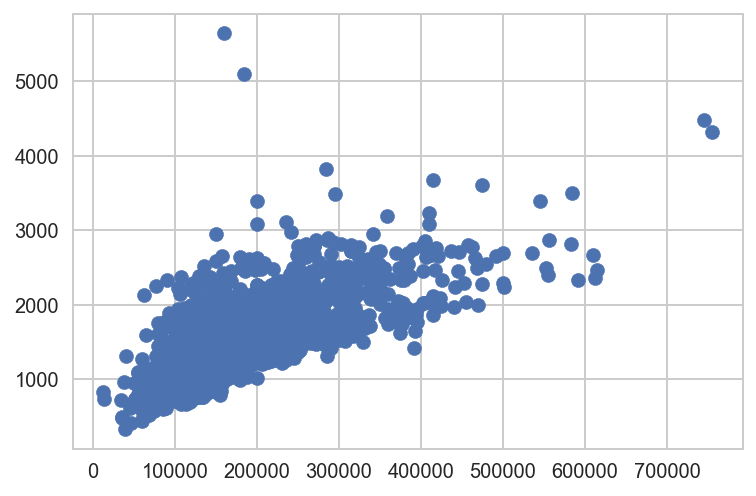

In [10]:
# Find outliers:
plt.Figure(figsize=(8,8))
plt.scatter(data['SalePrice'], data['Gr Liv Area'] );

In [11]:
#Remove very large houses (more than 4000 square feet) (this is included in the preprocessing function)
#df_clean = df_clean[df_clean['Gr Liv Area'] < 4000]

count      -4.000000
mean    -1483.850815
std      -495.860081
min      -328.185869
25%     -1112.978024
50%     -1432.726907
75%     -1732.537929
max     -5633.751733
Name: Gr Liv Area, dtype: float64


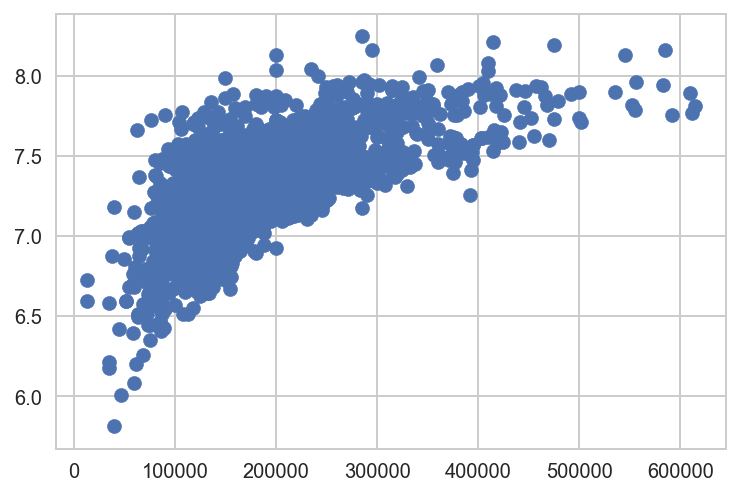

In [12]:
#impact of removing theses 4 outliers
a = df_clean['Gr Liv Area'].describe() - data['Gr Liv Area'].describe()
print(a)
plt.Figure(figsize=(8,8))
plt.scatter(df_clean['SalePrice'], df_clean['Gr Liv Area']  );
plt.show()

## 2. Encoding

In [13]:
# Function to one-hot data frame

def encode(df):
    df_encoded = df.copy()
    
    # One-hot encoding for nominal variables 
    df_encoded = pd.get_dummies(df_encoded, columns=categorical_nominal)
    
    print('Origina Size:', df.shape, 'Size when encoded:', df_encoded.shape)
    return df_encoded

In [14]:
df_encoded = encode(df_clean)

Origina Size: (2426, 111) Size when encoded: (2426, 278)


## 3. Feature engineering


Skewness: 1.790280
Kurtosis: 5.564973


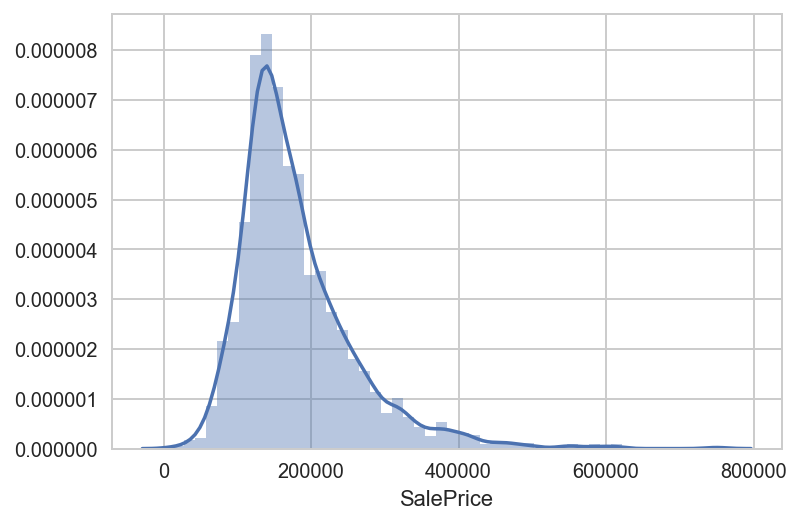

In [15]:
# Let's have a closer look at the target variable: before removing outliers, skewed distribution
sns.distplot(data['SalePrice']);
print("Skewness: %f" % data['SalePrice'].skew())
print("Kurtosis: %f" % data['SalePrice'].kurt())

Skewness: 1.604094
Kurtosis: 4.001173


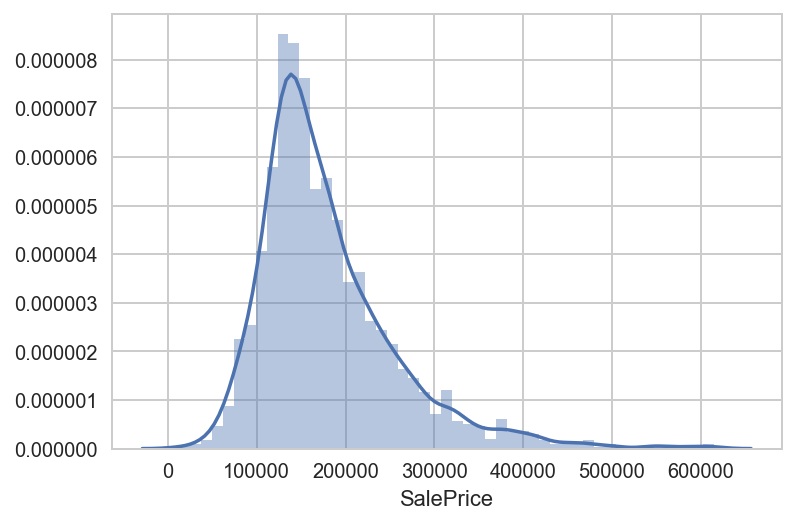

In [16]:
#After removing outliers, reduces skewness a bit
sns.distplot(df_clean['SalePrice']);
print("Skewness: %f" % df_clean['SalePrice'].skew())
print("Kurtosis: %f" % df_clean['SalePrice'].kurt())

In [17]:
# Add a LogSalePrice variable to the DataFrame (this is included in the preprocessing function)
#df_clean['LogSalePrice'] = np.log10(df_clean['SalePrice'])

Skewness: -0.092830
Kurtosis: 1.679439


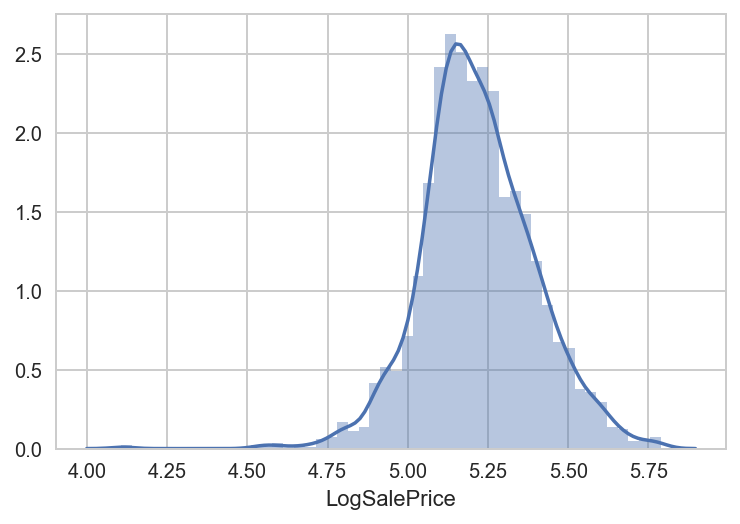

In [18]:
# plot of the log10 of SalePrice :, skewness reduced
sns.distplot(df_clean['LogSalePrice']);
print("Skewness: %f" % df_clean['LogSalePrice'].skew())
print("Kurtosis: %f" % df_clean['LogSalePrice'].kurt())

In [19]:
# Total surface count
#df_clean['TotalSF'] = df_clean['Total Bsmt SF'] + df_clean['Gr Liv Area']

# Total count of rooms
#df_clean['Total_rooms'] = (df_clean['TotRms AbvGrd'] + df_clean[''Bsmt Full Bath'] + 
#                                df_clean['Bsmt Half Bath'] + df_clean['Full Bath'] + df_clean['Half Bath']) 

# Adding a 'Remodeled' feature :
# If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
# df_clean["Remodeled"] = (df_clean["Year Remod/Add"] != df_clean["Year Built"]) * 1

    
# Creating a 'RecentRemodel' feature if a remodeling happenned in the year the house was sold
#df_clean['RecentRemodel'] = (df_clean['Year Remod/Add'] == df_clean['Yr Sold']) * 1
    
# Creating a 'NewHouse' featureWas this house sold in the year it was built?
#df_clean['NewHouse'] = (df_clean['Year Built'] == df_clean['Yr Sold']) * 1

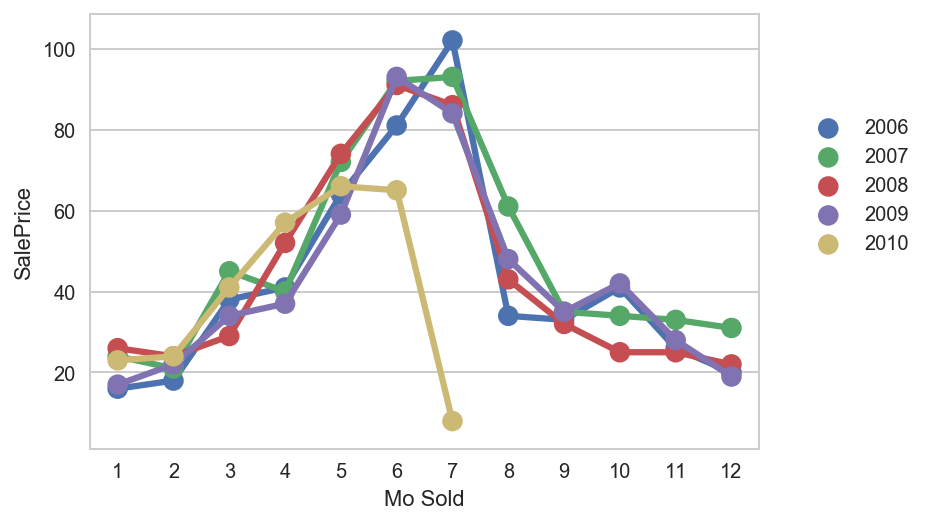

In [20]:
# Sale seasonality feature (high & low season)
#df_clean['Sale Season'] = df_clean['Mo Sold'].replace({1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:1, 9:0, 10:0, 11:0, 12:0})

#visual rerpresentation of sales per given month
grp = df_clean.groupby(['Yr Sold','Mo Sold'])
piv = grp.count()['SalePrice'].reset_index()
piv.columns = ['Overall Qual','Mo Sold','SalePrice']
sns.pointplot(x='Mo Sold', y='SalePrice', hue='Overall Qual', data=piv, join=True)
plt.legend(loc='best', bbox_to_anchor=(1.05, 0.8, 0.2, 0));

In [21]:
# Creation of a composite feature : TotalSF * Overall Quality:
# df_clean['OverallQualxTotalSF'] = df_clean['TotalSF'] * df_clean['Overall Qual']

In [22]:
# Add polynomial features for the 10 most correlated features

## 4. Feature selection

### 4.1 Univariate feature selection
Univariate feature selection examines each feature individually to determine the strength of the relationship of the feature with the response variable.



### 4.1.1 Pearson correlation coef
One of the simplest method for understanding a feature’s relation to the response variable is Pearson correlation coefficient, which measures linear correlation between two variables. The resulting value lies in [-1;1]

__Works good when linear relation between feature and target__

In [23]:
# Most correlated features in abs value
corr = df_clean.corr()
corr_abs = corr['SalePrice'].abs().sort_values(ascending=False)
print(corr_abs[:20])

SalePrice                1.000000
LogSalePrice             0.947439
Overall Qual_2           0.842266
Overall Qual_1           0.832560
OverallQualxTotalSF      0.828420
OverallQualxTotalSF_1    0.828393
OverallQualxTotalSF_2    0.828392
Total SF                 0.821375
Overall Qual             0.805112
Total SF_1               0.766747
Total SF_2               0.766747
Exter Qual_2             0.722927
Exter Qual_1             0.717915
Exter Qual               0.706781
Kitchen Qual_2           0.696542
Gr Liv Area              0.691521
Gr Liv Area_1            0.691495
Gr Liv Area_2            0.691495
Kitchen Qual_1           0.690083
Garage Cars_1            0.674860
Name: SalePrice, dtype: float64


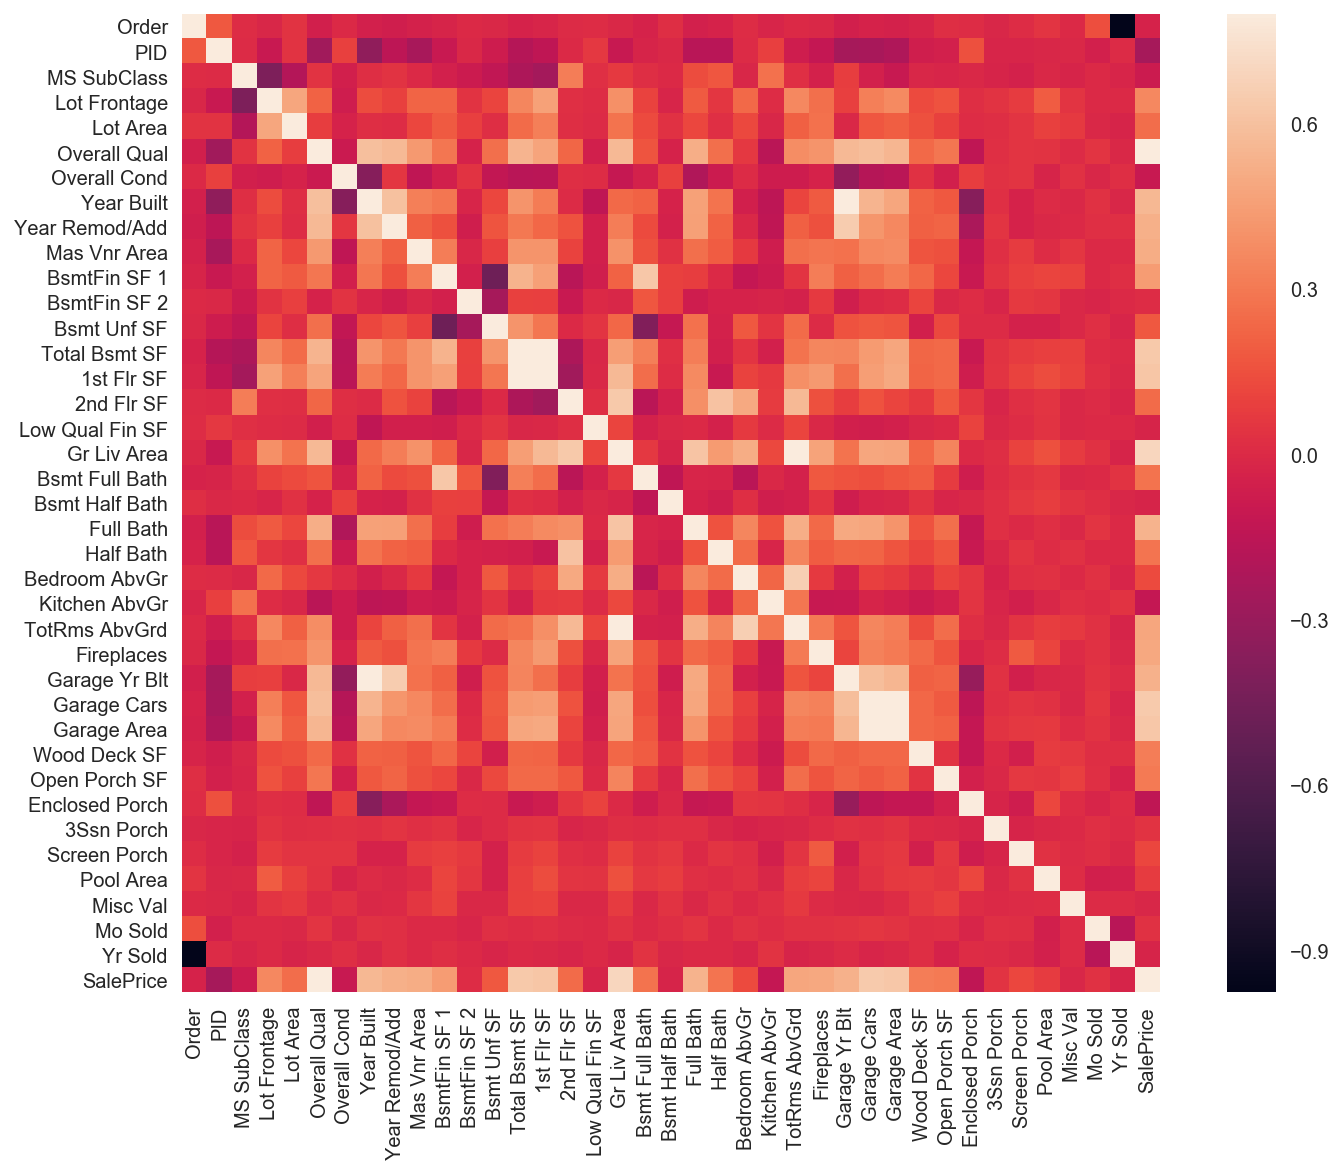

In [24]:
# same corr matrix but presented graphically:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [25]:
# we detect highly collinear variables in the heatmap (light squares) :
# Total Bsmt SF & 1st Floor SF
# Garage features

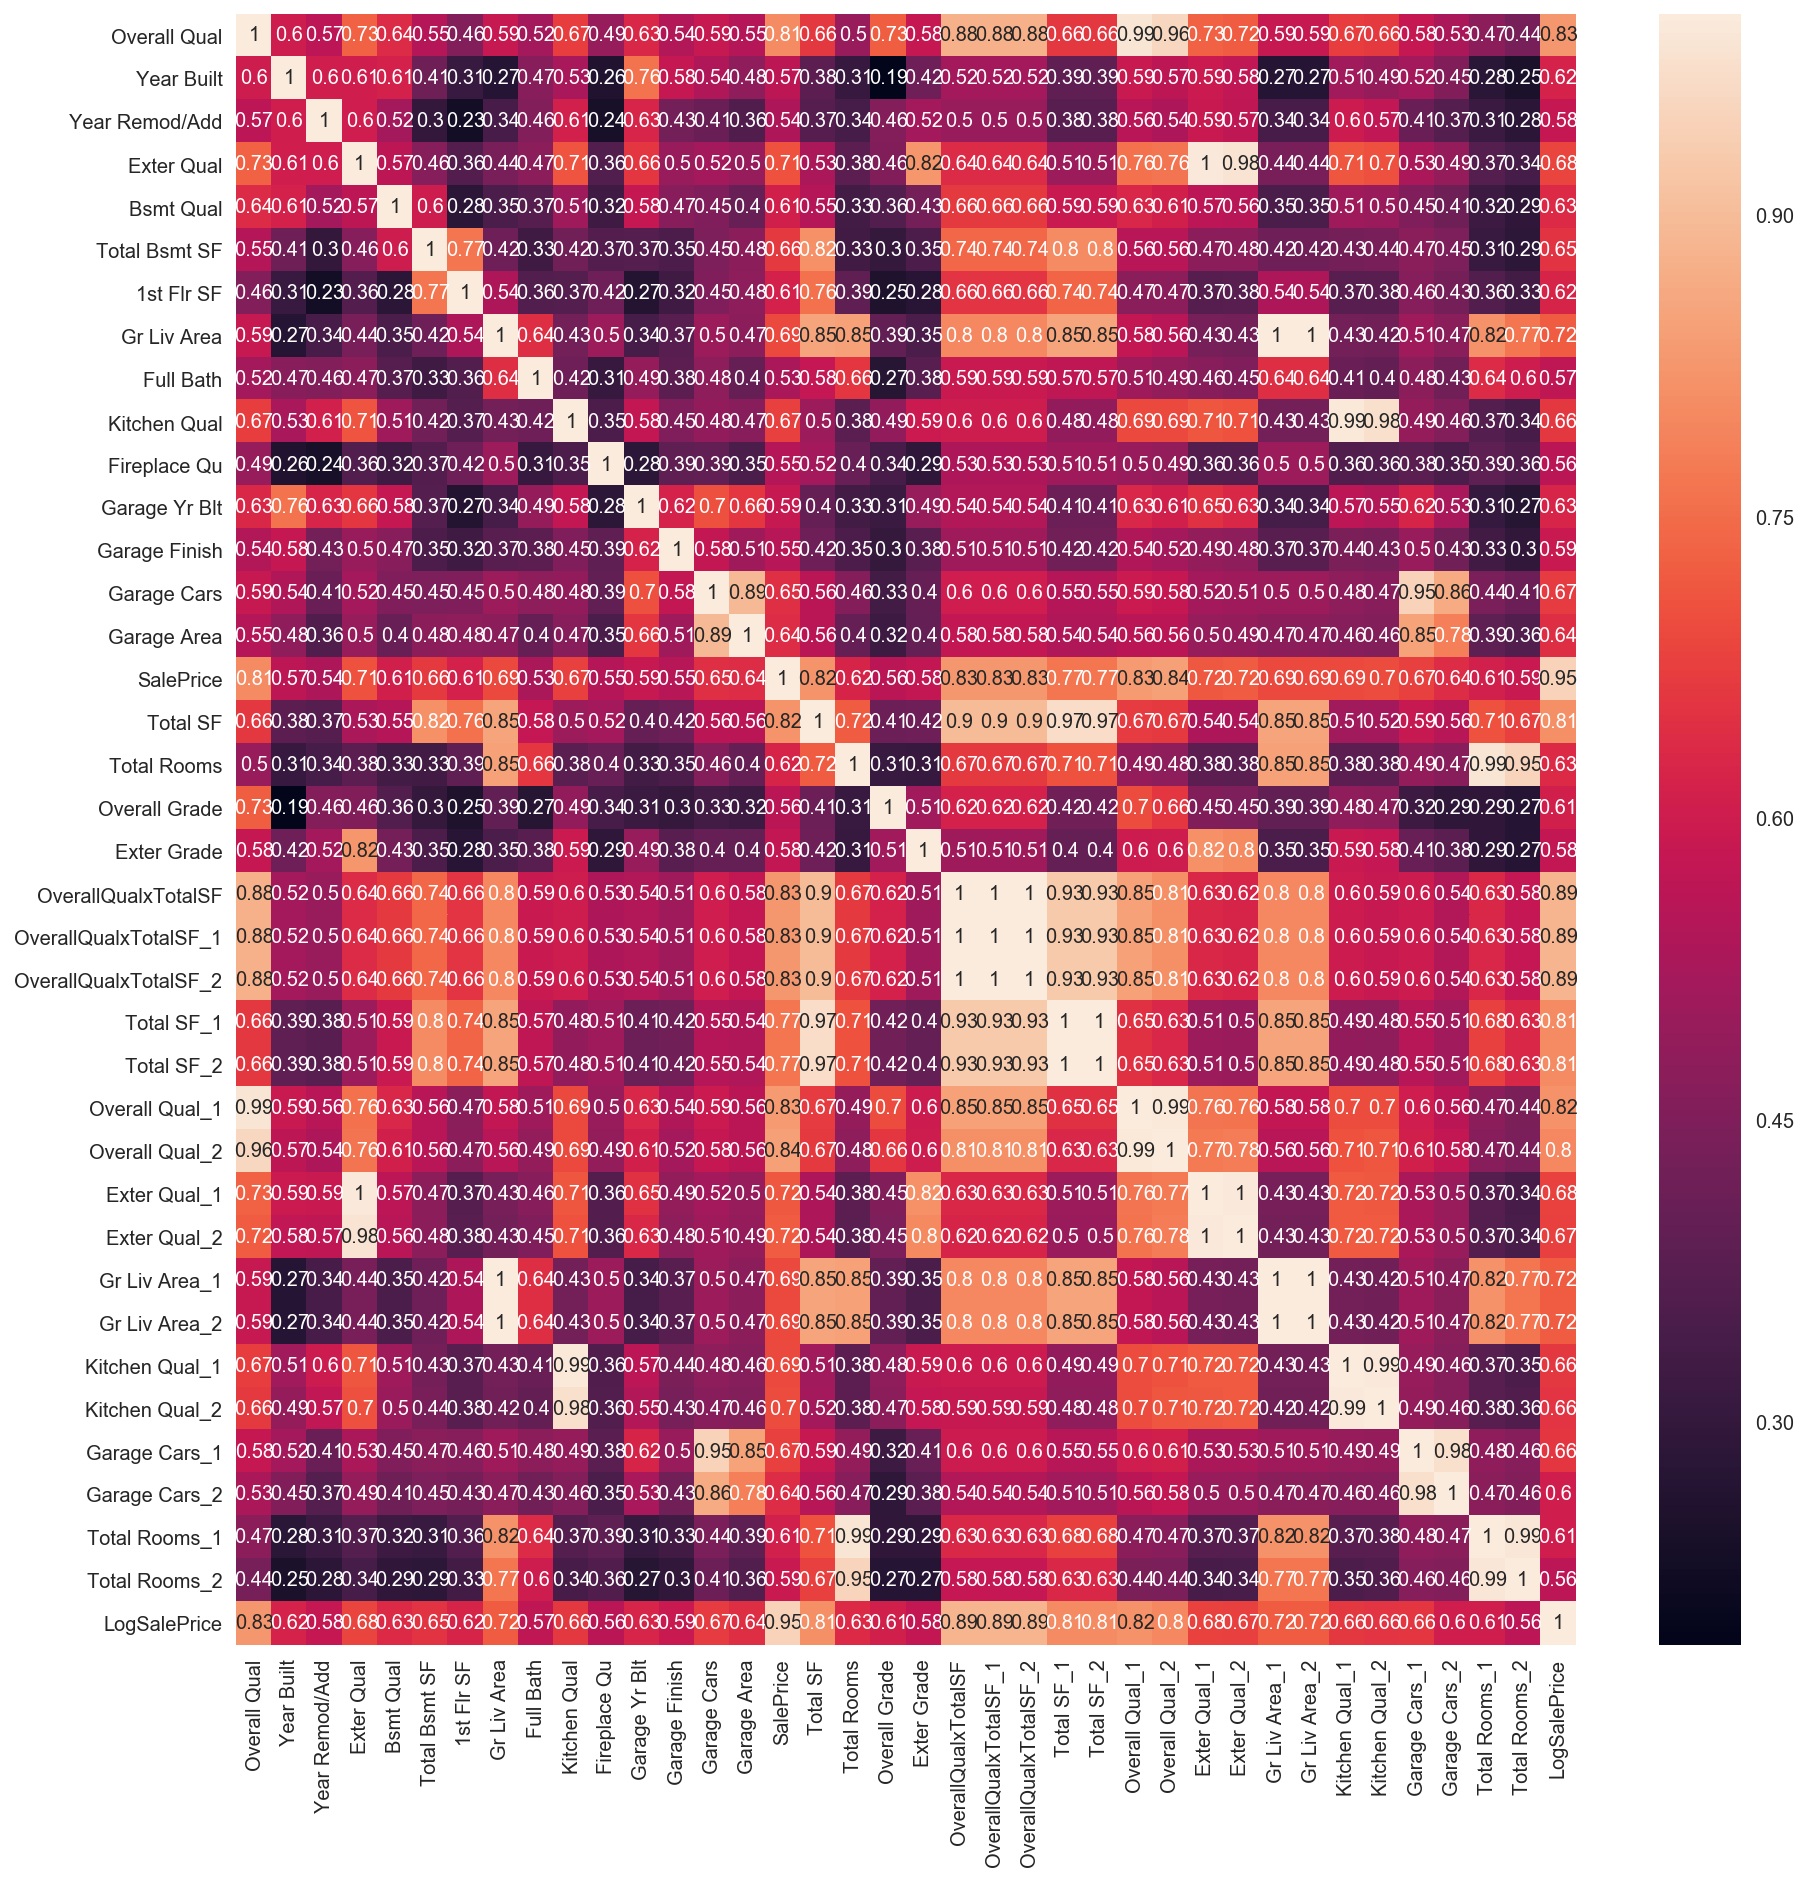

In [26]:
# most correlated features
corrmat = df_clean.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(15,15))
g = sns.heatmap(df_clean[top_corr_features].corr(),annot=True)

## 5. Model selection

In [27]:
# Split into train/test sets
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_encoded, train_size=0.5, test_size=0.5, random_state=0)

print('Train DataFrame:', train_df.shape)
print('Test DataFrame:', test_df.shape)

Train DataFrame: (1213, 278)
Test DataFrame: (1213, 278)


In [28]:
# Define error metric : 
# Root mean squared error
def RMSE(y, y_pred):
    mse = np.mean(np.square(y - y_pred)) 
    return np.sqrt(mse) 

# Mean absolute error
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))    

# function to create feature list from selected features
def create_features(feature_list):
    features = []
    for feature in feature_list:
        features.extend(df_encoded.filter(like=feature).columns.tolist())
    print('Selected features:', features, "\n")
    return features

# Function to create variables
def create_variables(features, target):
    X_tr, y_tr, X_te, y_te = None, None, None, None 
    X_tr = train_df[features].values
    y_tr = train_df[target].values
    X_te = test_df[features].values 
    y_te = test_df[target].values
    print('X_tr shape:', X_tr.shape, 'y_tr shape:', y_tr.shape,'X_te shape:', X_te.shape, 'y_te shape:', y_te.shape, "\n")
    return X_tr, y_tr, X_te, y_te

# Function to fit a linear regression
from sklearn.linear_model import LinearRegression, HuberRegressor

def fit_lr(X_train, y_train, X_test):
    # Create a linear regression
    lr = LinearRegression()
    
    # Fit it to train data
    lr.fit(X_train, y_train)
    
    # Compute predictions for test set
    y_pred = lr.predict(X_test)
    #print("Linear regression coefficients:",lr.coef_)
    return y_pred, lr

# Function to fit Ridge regression
from sklearn.linear_model import Ridge
def fit_ridge(X_train, y_train, X_test):
    ridge = Ridge(alpha=1) 
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    return y_pred, ridge

# Function to fit Ridge regression with GridSearchCV
from sklearn.model_selection import GridSearchCV
def fit_ridge_gs(X_train, y_train, X_test):
    ridge = Ridge()
    ridge_params_ = {'alpha': np.logspace(-5, 5, num=100).tolist() }
    grid_ridge = GridSearchCV(ridge, ridge_params_)

    # Fit to train data
    grid_ridge.fit(X_train, y_train)

    y_pred = grid_ridge.predict(X_test)
    print (grid_ridge.best_params_)
    return y_pred, grid_ridge   

In [29]:
# Implementing grid search for Ridge regression
def grid_search(X_train, y_train, X_test, y_test):   
   
    # Define a set of alpha values
    alphas = np.logspace(-5, 5, num=100) 
    
    # Save train/test scores
    train_scores = []
    test_scores = []
  
    #grid search
    for alpha in alphas:
    # Ridge regression
        ridge = Ridge(alpha)
        ridge.fit(X_train, y_train)
    
        # Train score
        y_pred = ridge.predict(X_train)
        train_scores.append(RMSE(y_train, y_pred))
    
        # Test score
        y_pred = ridge.predict(X_test)
        test_scores.append(RMSE(y_test, y_pred))
            
    # Find best alpha
    idx = np.argmin(test_scores)
    best_alpha = alphas[idx]
    print('Best alpha {:.1e}'.format(best_alpha))

    # Print train/test scores
    print('Ridge regression 2 - RMSE train: {:,f} test: {:,f}'.format(
    train_scores[idx],
    test_scores[idx]
))
    # Plot the validation curves
    plt.semilogx(alphas, train_scores, label='train curve')
    plt.semilogx(alphas, test_scores, label='test curve')
    plt.legend()
    plt.show()

    # Ridge regression with tuned alpha
    ridge2 = Ridge(best_alpha)
    ridge2.fit(X_train, y_train)
    y_pred = ridge2.predict(X_train)
    
    rmse_ridge2 = RMSE(y_test, y_pred)
    mae_ridge2 = MAE(10**y_test, 10**y_pred)
    print('RMSE Ridge: {:.3f}'.format(rmse_ridge2),"\n",'MAE Ridge: {:.3f}'.format(mae_ridge2))
    return ridge2

#### Computing baseline

In [30]:
# Create X/y variables
features = create_features(['Overall Qual', 'Gr Liv Area'])
X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

# Median baseline
rmse_baseline = RMSE(y_te, np.median(y_te))
mae_baseline = MAE(10**y_te, np.median(10**y_te))

print('RMSE baseline: {:.3f}'.format(rmse_baseline))
print('MAE baseline: {:.3f}'.format(mae_baseline))

Selected features: ['Overall Qual', 'Overall Qual_1', 'Overall Qual_2', 'Gr Liv Area', 'Gr Liv Area_1', 'Gr Liv Area_2'] 

X_tr shape: (1213, 6) y_tr shape: (1213,) X_te shape: (1213, 6) y_te shape: (1213,) 

RMSE baseline: 0.178
MAE baseline: 54125.121


#### "Simple" model with two variables (three with the target variable)


Selected features: ['Overall Qual', 'Overall Qual_1', 'Overall Qual_2', 'Gr Liv Area', 'Gr Liv Area_1', 'Gr Liv Area_2'] 

X_tr shape: (1213, 6) y_tr shape: (1213,) X_te shape: (1213, 6) y_te shape: (1213,) 

RMSE linear regression: 0.089
MAE linear regression: 24579.950 

RMSE Ridge: 0.089
MAE Ridge: 24597.390 

{'alpha': 0.44306214575838776}
RMSE Ridge GS: 0.089
MAE Ridge GS: 24613.771 

Best alpha 1.0e-05
Ridge regression 2 - RMSE train: 0.078755 test: 0.088551


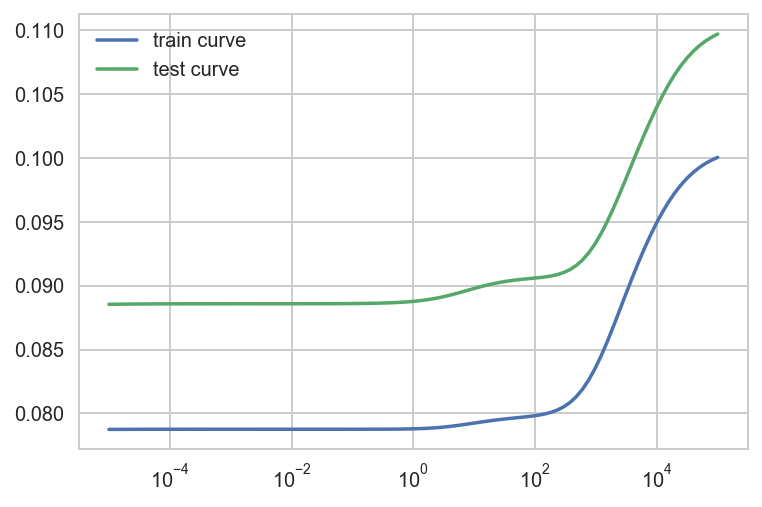

RMSE Ridge: 0.231 
 MAE Ridge: 74501.320


In [47]:
# Select features
features = create_features(['Overall Qual', 'Gr Liv Area'])

# Create X/y variables
X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

# Linear regression
y_pred, lr_simple1 = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)
print('RMSE linear regression: {:.3f}'.format(rmse_lr))
print('MAE linear regression: {:.3f}'.format(mae_lr), "\n")

#Ridge regression
y_pred, ridge_simple1 = fit_ridge(X_tr, y_tr, X_te)
rmse_ridge = RMSE(y_te, y_pred)
mae_ridge = MAE(10**y_te, 10**y_pred)
print('RMSE Ridge: {:.3f}'.format(rmse_ridge))
print('MAE Ridge: {:.3f}'.format(mae_ridge), "\n")

#Ridge regression with GridSearchCV
y_pred, grid_ridge_simple1 = fit_ridge_gs(X_tr, y_tr, X_te)
rmse_ridge_gs = RMSE(y_te, y_pred)
mae_ridge_gs = MAE(10**y_te, 10**y_pred)
print('RMSE Ridge GS: {:.3f}'.format(rmse_ridge_gs))
print('MAE Ridge GS: {:.3f}'.format(mae_ridge_gs), "\n")

#Ridge regression with grid search
ridge2_simple1 = grid_search(X_tr, y_tr, X_te, y_te)

#### "Simple" model with two variables (three with the target variable) - 2

Selected features: ['OverallQualxTotalSF', 'OverallQualxTotalSF_1', 'OverallQualxTotalSF_2', 'Exter Grade'] 

X_tr shape: (1213, 4) y_tr shape: (1213,) X_te shape: (1213, 4) y_te shape: (1213,) 

RMSE linear regression: 0.253
MAE linear regression: 21079.664 

RMSE Ridge: 0.082
MAE Ridge: 21977.617 

{'alpha': 1e-05}
RMSE Ridge GS: 0.081
MAE Ridge GS: 21889.753
Best alpha 1.0e-05
Ridge regression 2 - RMSE train: 0.073595 test: 0.080835


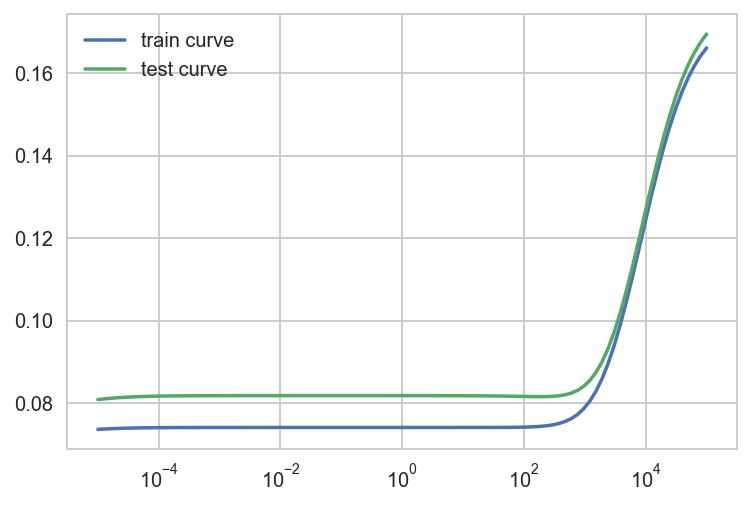

RMSE Ridge: 0.234 
 MAE Ridge: 73965.904


In [45]:
features = create_features(['OverallQualxTotalSF', 'Exter Grade'])

# Create X/y variables
X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

# Linear regression
y_pred, lr_simple2 = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)
print('RMSE linear regression: {:.3f}'.format(rmse_lr))
print('MAE linear regression: {:.3f}'.format(mae_lr), "\n")

#Ridge regression
y_pred, ridge_simple2 = fit_ridge(X_tr, y_tr, X_te)
rmse_ridge = RMSE(y_te, y_pred)
mae_ridge = MAE(10**y_te, 10**y_pred)
print('RMSE Ridge: {:.3f}'.format(rmse_ridge))
print('MAE Ridge: {:.3f}'.format(mae_ridge), "\n")

#Ridge regression with GridSearchCV
y_pred, grid_ridge_simple2 = fit_ridge_gs(X_tr, y_tr, X_te)
rmse_ridge_gs = RMSE(y_te, y_pred)
mae_ridge_gs = MAE(10**y_te, 10**y_pred)
print('RMSE Ridge GS: {:.3f}'.format(rmse_ridge_gs))
print('MAE Ridge GS: {:.3f}'.format(mae_ridge_gs), "\n")

#Ridge regression with grid search
ridge2_simple2 = grid_search(X_tr, y_tr, X_te, y_te)

#### "Simple" model with two variables (three with the target variable) - 3

Selected features: ['OverallQualxTotalSF', 'OverallQualxTotalSF_1', 'OverallQualxTotalSF_2', 'Sale Condition_Abnorml', 'Sale Condition_AdjLand', 'Sale Condition_Alloca', 'Sale Condition_Family', 'Sale Condition_Normal', 'Sale Condition_Partial'] 

X_tr shape: (1213, 9) y_tr shape: (1213,) X_te shape: (1213, 9) y_te shape: (1213,) 

RMSE linear regression: 0.298
MAE linear regression: 20993.308 

RMSE Ridge: 0.082
MAE Ridge: 22569.434 

{'alpha': 1e-05}
RMSE Ridge GS: 0.081
MAE Ridge GS: 22428.851
Best alpha 1.0e-05
Ridge regression 2 - RMSE train: 0.074367 test: 0.081215


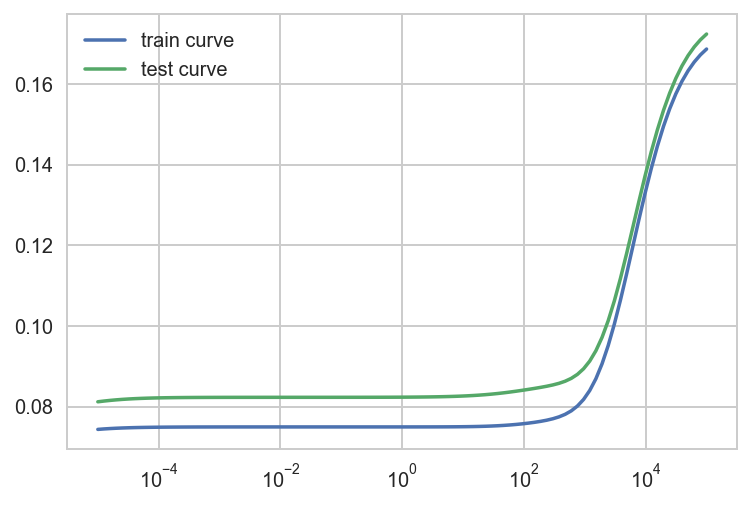

RMSE Ridge: 0.234 
 MAE Ridge: 73393.972


In [44]:
features = create_features(['OverallQualxTotalSF', 'Sale Cond'])

# Create X/y variables
X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

# Linear regression
y_pred, lr_simple3 = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)
print('RMSE linear regression: {:.3f}'.format(rmse_lr))
print('MAE linear regression: {:.3f}'.format(mae_lr), "\n")

#Ridge regression
y_pred, ridge_simple3 = fit_ridge(X_tr, y_tr, X_te)
rmse_ridge = RMSE(y_te, y_pred)
mae_ridge = MAE(10**y_te, 10**y_pred)
print('RMSE Ridge: {:.3f}'.format(rmse_ridge))
print('MAE Ridge: {:.3f}'.format(mae_ridge), "\n")

#Ridge regression with GridSearchCV
y_pred, grid_ridge_simple3 = fit_ridge_gs(X_tr, y_tr, X_te)
rmse_ridge_gs = RMSE(y_te, y_pred)
mae_ridge_gs = MAE(10**y_te, 10**y_pred)
print('RMSE Ridge GS: {:.3f}'.format(rmse_ridge_gs))
print('MAE Ridge GS: {:.3f}'.format(mae_ridge_gs), "\n")

#Ridge regression with grid search
ridge2_simple3 = grid_search(X_tr, y_tr, X_te, y_te)

#### Intermediate model

Selected features: ['OverallQualxTotalSF', 'OverallQualxTotalSF_1', 'OverallQualxTotalSF_2', 'Exter Qual', 'Exter Qual_1', 'Exter Qual_2', 'Total SF', 'Total SF_1', 'Total SF_2', 'Overall Qual', 'Overall Qual_1', 'Overall Qual_2', 'Gr Liv Area', 'Gr Liv Area_1', 'Gr Liv Area_2', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Garage Grade', 'Garage Cars_1', 'Garage Cars_2', 'Garage Area_1', 'Garage Area_2', 'Garage Type_2Types', 'Garage Type_Attchd', 'Garage Type_Basment', 'Garage Type_BuiltIn', 'Garage Type_CarPort', 'Garage Type_Detchd', 'Garage Type_NA', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens', 'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborh

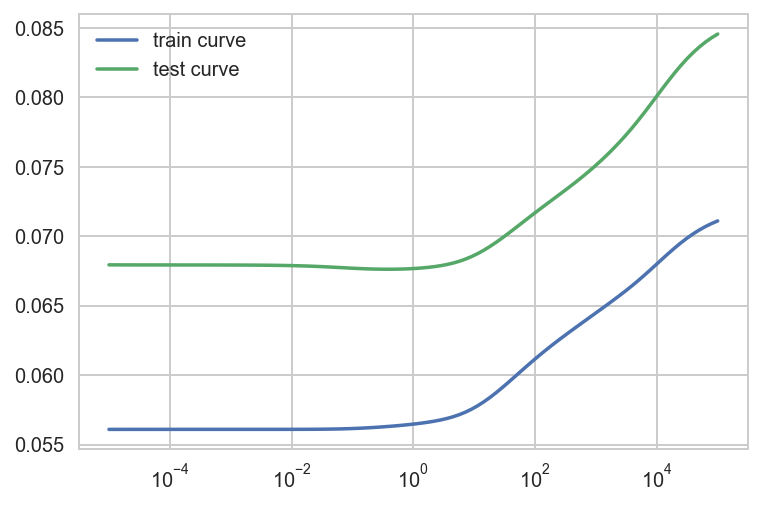

RMSE Ridge: 0.238 
 MAE Ridge: 77343.867


In [43]:
features = create_features(['OverallQualxTotalSF', 'Exter Qual', 'Total SF', 'Overall Qual', 'Gr Liv Area',
                            'Garage', 'Neighborhood', 'Remodeled', 'RecentRemodel', 'NewHouse', 'Sale Season'])

# Create X/y variables
X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

# Linear regression
y_pred, lr_inter = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)
print('RMSE linear regression: {:.3f}'.format(rmse_lr))
print('MAE linear regression: {:.3f}'.format(mae_lr), "\n")

#Ridge regression
y_pred, ridge_inter = fit_ridge(X_tr, y_tr, X_te)
rmse_ridge = RMSE(y_te, y_pred)
mae_ridge = MAE(10**y_te, 10**y_pred)
print('RMSE Ridge: {:.3f}'.format(rmse_ridge))
print('MAE Ridge: {:.3f}'.format(mae_ridge), "\n")

#Ridge regression with GridSearchCV
y_pred, grid_ridge_inter = fit_ridge_gs(X_tr, y_tr, X_te)
rmse_ridge_gs = RMSE(y_te, y_pred)
mae_ridge_gs = MAE(10**y_te, 10**y_pred)
print('RMSE Ridge GS: {:.3f}'.format(rmse_ridge_gs))
print('MAE Ridge GS: {:.3f}'.format(mae_ridge_gs), "\n")

#Ridge regression with grid search
ridge2_inter = grid_search(X_tr, y_tr, X_te, y_te)

#### Model with all the features

X_tr shape: (1213, 276) y_tr shape: (1213,) X_te shape: (1213, 276) y_te shape: (1213,) 

RMSE linear regression: 0.265
MAE linear regression: 5955066502.027 

RMSE Ridge: 0.055
MAE Ridge: 13090.285 

{'alpha': 14.508287784959402}
RMSE Ridge GS: 0.054
MAE Ridge GS: 12929.361 

Best alpha 7.2e+00
Ridge regression 2 - RMSE train: 0.037830 test: 0.053731


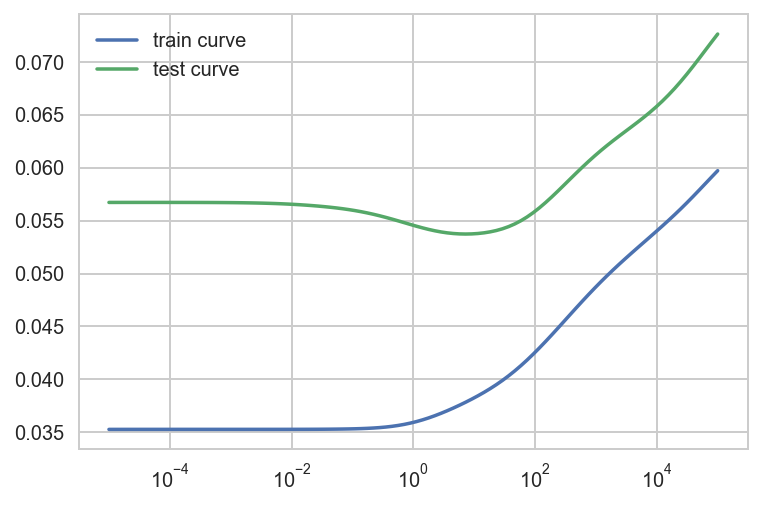

RMSE Ridge: 0.240 
 MAE Ridge: 77198.677


In [35]:
# Fitting a model with all the features
columns_to_exclude = ['SalePrice','LogSalePrice']
features = df_encoded.drop(columns_to_exclude, axis = 1).columns

# Create variables
X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

# Linear regression
y_pred, lr_complex = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)
print('RMSE linear regression: {:.3f}'.format(rmse_lr))
print('MAE linear regression: {:.3f}'.format(mae_lr), "\n")

#Ridge regression
y_pred, ridge_complex = fit_ridge(X_tr, y_tr, X_te)
rmse_ridge = RMSE(y_te, y_pred)
mae_ridge = MAE(10**y_te, 10**y_pred)
print('RMSE Ridge: {:.3f}'.format(rmse_ridge))
print('MAE Ridge: {:.3f}'.format(mae_ridge), "\n")

#Ridge regression with GridSearchCV
y_pred, grid_ridge_complex = fit_ridge_gs(X_tr, y_tr, X_te)
rmse_ridge_gs = RMSE(y_te, y_pred)
mae_ridge_gs = MAE(10**y_te, 10**y_pred)
print('RMSE Ridge GS: {:.3f}'.format(rmse_ridge_gs))
print('MAE Ridge GS: {:.3f}'.format(mae_ridge_gs), '\n')


#Ridge regression with grid search
ridge2_complex = grid_search(X_tr, y_tr, X_te, y_te)

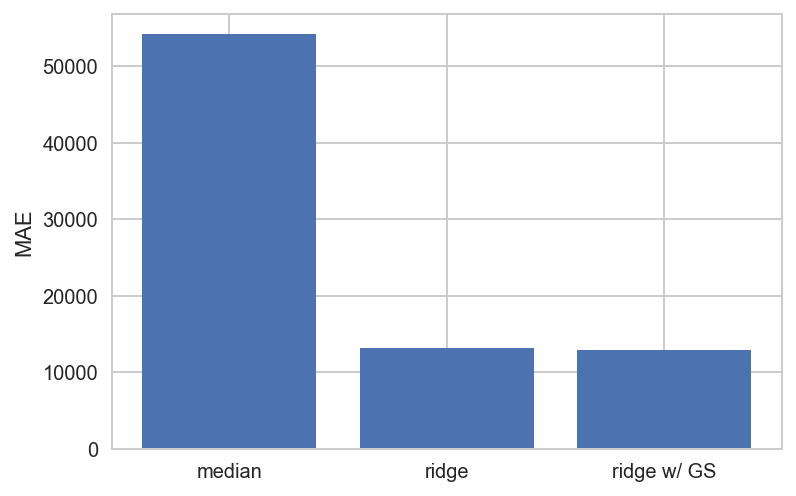

In [36]:
# Final comparison
mae_values = [mae_baseline, mae_ridge, mae_ridge_gs]
titles = ['median', 'ridge', 'ridge w/ GS']

xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)

plt.ylabel('MAE')
plt.show()

## 6. Computing predictions

### Pre-processing the test data

In [37]:
# loading the test data
test_data = pd.read_csv('house-prices-test.csv')
print('Test dataset has {} entries and {} features.'.format(test_data.shape[0], test_data.shape[1]))

Test dataset has 500 entries and 81 features.


In [38]:
test_clean = preprocess_df(test_data)

Dataset has 499 entries and 109 features.
There are 0 missing values remaining.


In [39]:
# Check the skewness of numerical features
numeric_features = pd.Index(numeric)

skewed_features = test_clean[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[abs(skewed_features) > 0.75]
print("\nSkewed numerical features to log transform: \n")
skewness = pd.DataFrame({'Skew' :skewed_features})
skewness.sort_values(by='Skew', ascending = False)


Skewed numerical features to log transform: 



,Skew
Pool Area,22.271103
Misc Val,10.190402
Low Qual Fin SF,9.369858
3Ssn Porch,9.271669
Total Bsmt SF_2,6.053677
Screen Porch,5.026317
OverallQualxTotalSF_2,4.978611
BsmtFin SF 2,4.752445
Total SF_2,3.782359
Garage Area_2,3.432281


In [40]:
# Log transform of the skewed numerical features 
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed

skewness = skewness[abs(skewness) > 0.75]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
test_clean[skewed_features] = np.log1p(test_clean[skewed_features])

28 skewed numerical features to log transform


In [41]:
test_encoded = encode(test_clean)

Origina Size: (499, 109) Size when encoded: (499, 248)


In [48]:
# 278 in train df vs. 248 in test !
# example of mismatch :
test_clean['MS SubClass'].unique() - df_clean['MS SubClass'].unique()

ValueError: operands could not be broadcast together with shapes (15,) (16,) 

In [49]:
# Reindex DataFrame with columns from the train set
# New columns were removed and missing ones created with NaN : fill them with 0
test_reindexed = test_encoded.reindex(
    columns=df_encoded.columns, fill_value = 0)

In [50]:
# Control
print(test_reindexed.shape)
print(df_encoded.shape)
print(test_reindexed.isnull().sum().sum())

(499, 278)
(2426, 278)
0


In [51]:
# checking if columns are the same between train & validation set
missing = set(df_encoded.columns) - set(test_reindexed.columns)
missing
#[c for c in missing if '_' not in c]

set()

/Applications/Anaconda/anaconda3/envs/exts-aml1/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


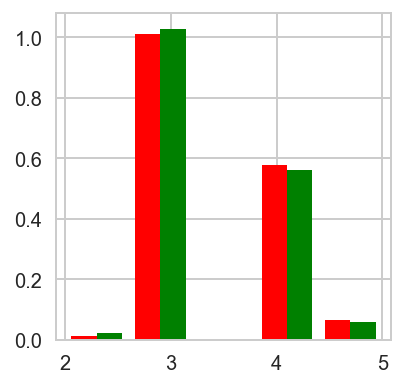

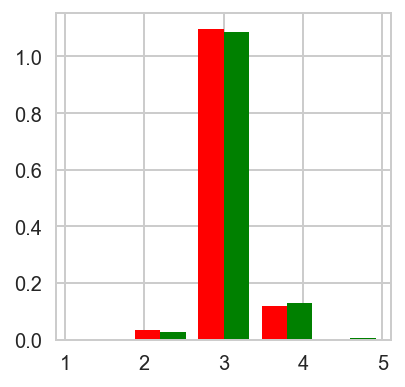

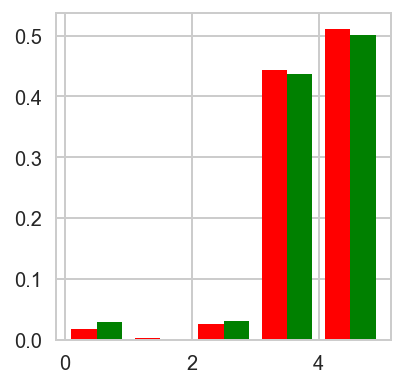

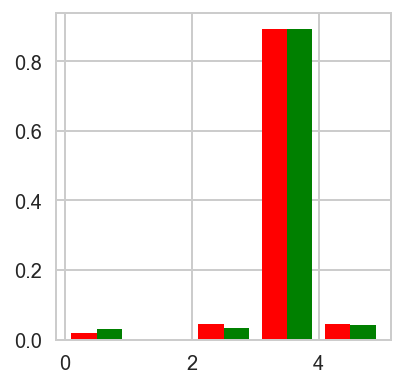

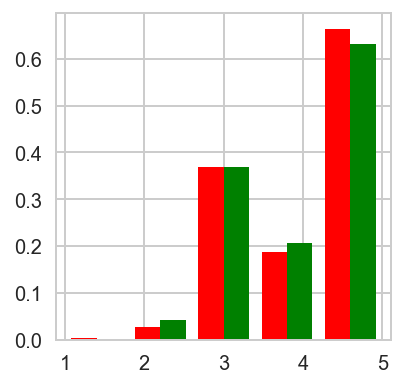

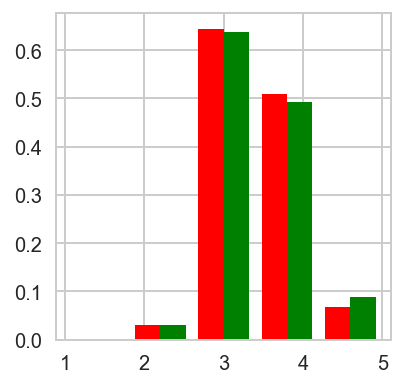

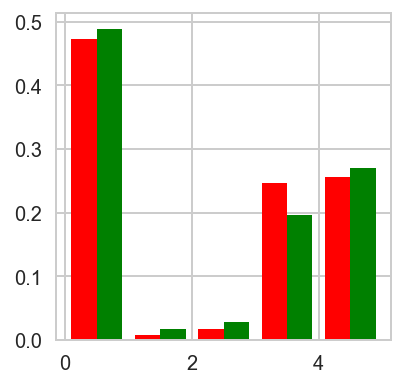

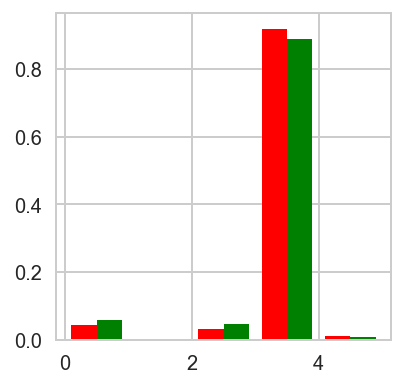

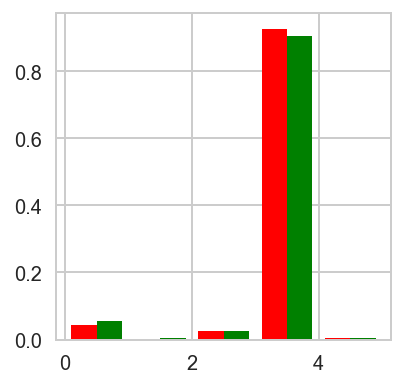

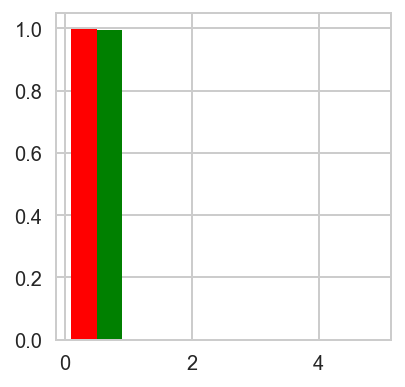

In [52]:
# checking if ordinal columns are encoded the same way
# comparing distributions : looks similar 
quality_features = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC', 'Kitchen Qual',
                    'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Pool QC']
for c in quality_features:
    plt.figure(figsize=(3,3))
    plt.hist([test_reindexed[c], df_encoded[c]], bins=5, color=['r', 'g'], normed=1 
            )

/Applications/Anaconda/anaconda3/envs/exts-aml1/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


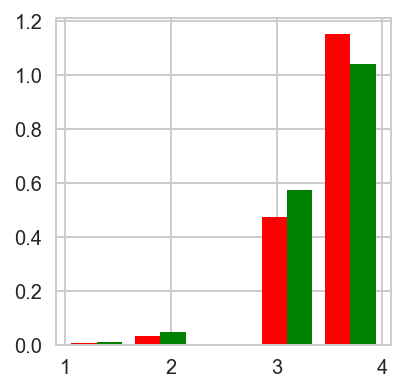

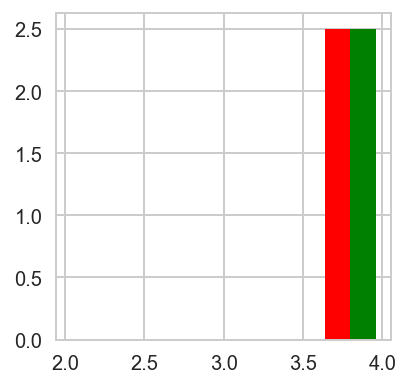

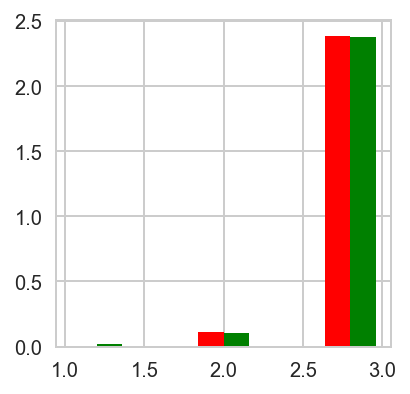

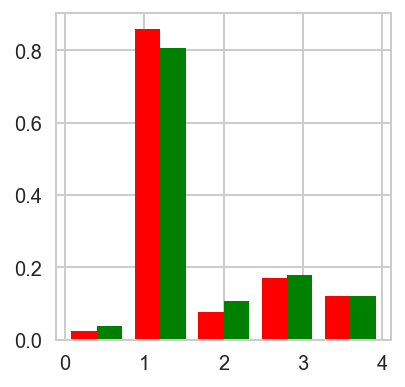

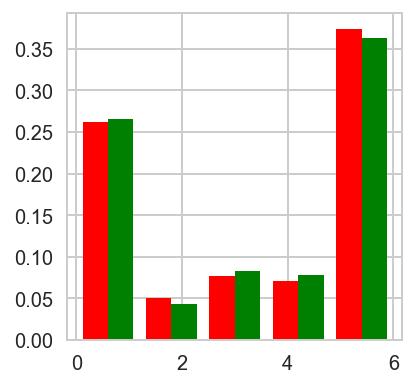

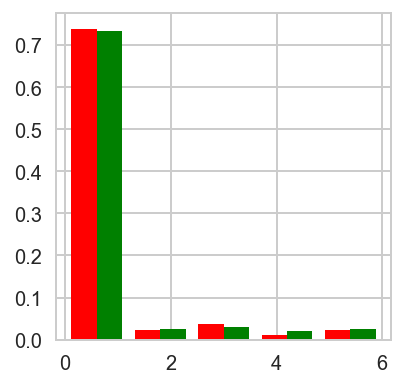

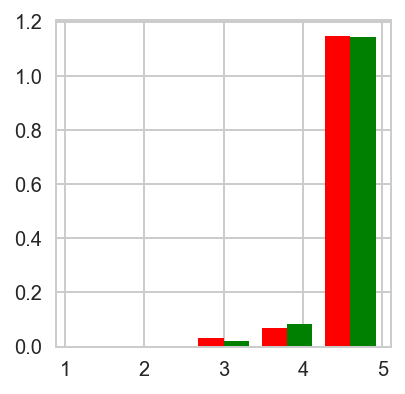

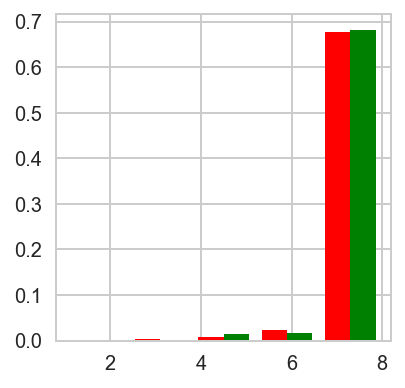

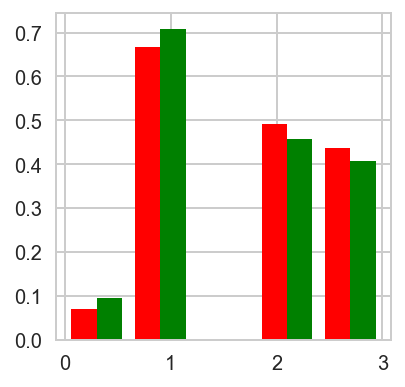

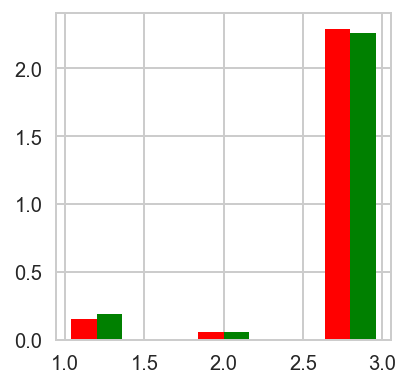

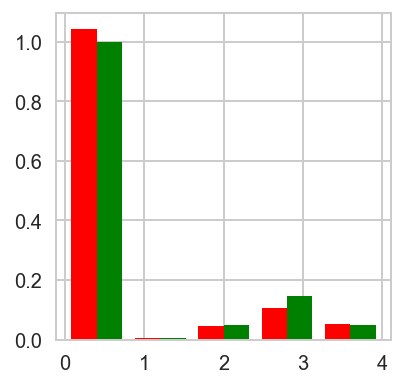

In [53]:
other_ord_features = ['Lot Shape' , 'Utilities' ,'Land Slope','Bsmt Exposure','BsmtFin Type 1',
                      'BsmtFin Type 2' ,'Electrical','Functional','Garage Finish',
                      'Paved Drive' ,'Fence']
for c in other_ord_features:
    plt.figure(figsize=(3,3))
    plt.hist([test_reindexed[c], df_encoded[c]], bins=5, color=['r', 'g'], normed=1 
            )

### Make predictions using the best model : complex ridge regression with GS & CV

In [54]:
# creating X
columns_to_exclude = ['SalePrice','LogSalePrice']
features = test_reindexed.drop(columns_to_exclude, axis = 1).columns
X = test_reindexed[features].values
X.shape

(499, 276)

In [55]:
# Convert predictions to dollars
predictions = 10**grid_ridge_complex.best_estimator_.predict(X)
#predictions = 10**grid_ridge_complex.predict(X)
#predictions = 10**ridge_complex.predict(X)

In [56]:
# Create DataFrame for predictions
## To DO : add PID 

predictions_df = pd.DataFrame.from_items([
    ('PID', ...
    ),
    ('SalePrice', predictions)])

In [57]:
predictions_df.head()

,PID,SalePrice
0,Ellipsis,393895.006880
1,Ellipsis,318842.158955
2,Ellipsis,720169.960389
3,Ellipsis,316480.485069
4,Ellipsis,209069.663717


In [58]:
# Distribution of the predicted prices
predictions_df.SalePrice.describe()

count    4.990000e+02
mean     4.080346e+05
std      2.606126e+05
min      8.477152e+04
25%      2.448669e+05
50%      3.425346e+05
75%      4.689810e+05
max      1.974159e+06
Name: SalePrice, dtype: float64

In [59]:
# Distribution of the prices in house-prices.csv
data.SalePrice.describe()

count      2430.000000
mean     180199.692593
std       79607.467171
min       12789.000000
25%      129000.000000
50%      160000.000000
75%      213099.750000
max      755000.000000
Name: SalePrice, dtype: float64

### Making predicitons - complex linear regression model

In [60]:
# Convert predictions to dollars
predictions_lr = 10**lr_complex.predict(X)

In [61]:
# Create DataFrame for predictions
## To DO : add PID 

predictions_lr_df = pd.DataFrame.from_items([
    ('PID', ...
    ),
    ('SalePrice', predictions_lr)])

In [62]:
# Distribution of the predicted prices
predictions_lr_df.SalePrice.describe()

count    4.990000e+02
mean     7.035000e+05
std      6.192742e+05
min      8.973482e+04
25%      3.666573e+05
50%      5.242341e+05
75%      7.653939e+05
max      4.730420e+06
Name: SalePrice, dtype: float64

### Making predicitons  - complex ridge regression with manual GS

In [63]:
# Convert predictions to dollars
predictions_ridge = 10**ridge2_complex.predict(X)

In [64]:
# Create DataFrame for predictions
## To DO : add PID 

predictions_ridge_df = pd.DataFrame.from_items([
    ('PID', ...
    ),
    ('SalePrice', predictions_ridge)])

In [65]:
# Distribution of the predicted prices
predictions_ridge_df.SalePrice.describe()

count    4.990000e+02
mean     4.690409e+05
std      3.250045e+05
min      8.710315e+04
25%      2.696806e+05
50%      3.878276e+05
75%      5.312400e+05
max      2.463571e+06
Name: SalePrice, dtype: float64

### Making predicitons  - intermediate linear regression model

In [66]:
features = create_features(['OverallQualxTotalSF', 'Exter Qual', 'Total SF', 'Overall Qual', 'Gr Liv Area',
                            'Garage', 'Neighborhood', 'Remodeled', 'RecentRemodel', 'NewHouse', 'Sale Season'])
X = test_reindexed[features].values
X.shape

Selected features: ['OverallQualxTotalSF', 'OverallQualxTotalSF_1', 'OverallQualxTotalSF_2', 'Exter Qual', 'Exter Qual_1', 'Exter Qual_2', 'Total SF', 'Total SF_1', 'Total SF_2', 'Overall Qual', 'Overall Qual_1', 'Overall Qual_2', 'Gr Liv Area', 'Gr Liv Area_1', 'Gr Liv Area_2', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Garage Grade', 'Garage Cars_1', 'Garage Cars_2', 'Garage Area_1', 'Garage Area_2', 'Garage Type_2Types', 'Garage Type_Attchd', 'Garage Type_Basment', 'Garage Type_BuiltIn', 'Garage Type_CarPort', 'Garage Type_Detchd', 'Garage Type_NA', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens', 'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborh

(499, 69)

In [67]:
# Convert predictions to dollars
predictions_lr = 10**lr_inter.predict(X)

In [68]:
# Create DataFrame for predictions
## To DO : add PID 

predictions_lr_df = pd.DataFrame.from_items([
    ('PID', ...
    ),
    ('SalePrice', predictions_lr)])

In [69]:
# Distribution of the predicted prices
predictions_lr_df.SalePrice.describe()

count       499.000000
mean     180659.413102
std       76635.097855
min       48786.051779
25%      127806.045683
50%      162080.437465
75%      206332.696481
max      563905.536684
Name: SalePrice, dtype: float64

In [70]:
# Using Ridge 
predictions_ridge = 10**ridge_inter.predict(X)
predictions_ridge_df = pd.DataFrame.from_items([
    ('PID', ...
    ),
    ('SalePrice', predictions_ridge)])
predictions_ridge_df.SalePrice.describe()

count       499.000000
mean     129498.380095
std       40972.624492
min       44352.305704
25%      100843.514608
50%      121587.799984
75%      148326.085461
max      307939.989451
Name: SalePrice, dtype: float64

### Making predicitons - simple linear regression model

In [71]:
# using simple model 3
# Select features
features = create_features(['OverallQualxTotalSF', 'Sale Cond'])
X = test_reindexed[features].values
X.shape

Selected features: ['OverallQualxTotalSF', 'OverallQualxTotalSF_1', 'OverallQualxTotalSF_2', 'Sale Condition_Abnorml', 'Sale Condition_AdjLand', 'Sale Condition_Alloca', 'Sale Condition_Family', 'Sale Condition_Normal', 'Sale Condition_Partial'] 



(499, 9)

In [72]:
# Linear regression

# Convert predictions to dollars
predictions_simple = 10**lr_simple3.predict(X)
predictions_simple_df = pd.DataFrame.from_items([
    ('PID',...
#,test_data['PID']
    ),
    ('SalePrice', predictions_simple)])
# Distribution of the predicted prices
predictions_simple_df.SalePrice.describe()

count       499.000000
mean     182275.301787
std       74751.233138
min       69648.821575
25%      128168.451698
50%      162619.550421
75%      214033.330997
max      529087.216542
Name: SalePrice, dtype: float64

In [73]:
# Ridge regression

# Convert predictions to dollars
predictions_simple = 10**ridge_simple3.predict(X)
predictions_simple_df = pd.DataFrame.from_items([
    ('PID',...
#,test_data['PID']
    ),
    ('SalePrice', predictions_simple)])
# Distribution of the predicted prices
predictions_simple_df.SalePrice.describe()

count       499.000000
mean     180904.955033
std       66054.417039
min       43603.131586
25%      132866.645401
50%      167799.707742
75%      217280.591810
max      422541.672265
Name: SalePrice, dtype: float64

In [74]:
# Ridge w GS & CV 

# Convert predictions to dollars
predictions_simple = 10**grid_ridge_simple3.predict(X)
predictions_simple_df = pd.DataFrame.from_items([
    ('PID',...
#,test_data['PID']
    ),
    ('SalePrice', predictions_simple)])
# Distribution of the predicted prices
predictions_simple_df.SalePrice.describe()

count       499.000000
mean     180980.735983
std       66611.521936
min       45185.155118
25%      132295.609353
50%      167559.976886
75%      217295.667168
max      427429.242361
Name: SalePrice, dtype: float64